In [49]:
from ansys.dpf import post
from ansys.dpf import core as dpf
from ansys.dpf.core import MeshedRegion
from ansys.dpf.post import examples, DataFrame, Mesh
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, MessagePassing
# from torch_geometric.loader import DataLoader
from torch import nn
from torch.utils.data import Dataset, DataLoader
from utils.data_loader import FEMDataset
import os

In [50]:
server = dpf.start_local_server(ansys_path=r"C:\Program Files\ANSYS Inc\v242", as_global=True)

In [202]:
ds = dpf.DataSources()
binout_path = os.path.join('.', "output", "d3plot")
ds.set_result_file_path(binout_path, "d3plot")
model = dpf.Model(ds)
print(model)

# binout = examples.download_binout_matsum()
# ds = dpf.DataSources()
# ds.set_result_file_path(binout, "binout")
# model = dpf.Model(ds)
# print(model)

DPF Model
------------------------------
Unknown analysis
Unit system: Undefined
Physics Type: Unknown
Available results:
     -  global_kinetic_energy: TimeFreq_steps Global Kinetic Energy
     -  global_internal_energy: TimeFreq_steps Global Internal Energy
     -  global_total_energy: TimeFreq_steps Global Total Energy
     -  global_velocity: TimeFreq_steps Global Velocity
     -  initial_coordinates: Nodal Initial Coordinates
     -  coordinates: Nodal Coordinates
     -  velocity: Nodal Velocity      
     -  acceleration: Nodal Acceleration
     -  stress: Elemental Stress      
     -  stress_von_mises: Elemental Stress Von Mises
     -  plastic_strain_eqv: Elemental Plastic Strain Eqv
     -  thickness: Elemental Thickness
     -  shell_x_membrane_resultant: Elemental Shell X Membrane Resultant
     -  shell_y_membrane_resultant: Elemental Shell Y Membrane Resultant
     -  shell_xy_membrane_resultant: Elemental Shell Xy Membrane Resultant
     -  shell_x_bending_resultant: El

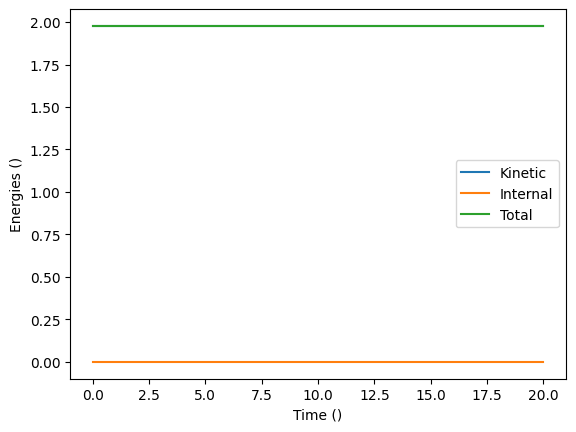

In [146]:
import matplotlib.pyplot as plt

K = model.results.global_kinetic_energy().eval()
U = model.results.global_internal_energy().eval()
H = model.results.global_total_energy().eval()

plt.plot(K.time_freq_support.time_frequencies.data, K[0].data, label="Kinetic")
plt.plot(U.time_freq_support.time_frequencies.data, U[0].data, label="Internal")
plt.plot(H.time_freq_support.time_frequencies.data, H[0].data, label="Total")
plt.xlabel("Time ({:s})".format(K.time_freq_support.time_frequencies.unit))
plt.ylabel("Energies ({:s})".format(K[0].unit))
plt.legend()
plt.show()

In [133]:
time_step = model.metadata.time_freq_support.time_frequencies.data
len(time_step)

202

In [91]:
model.results.velocity.on_all_time_freqs.eval()

over_time_disp = model.results.displacement.eval()
over_time_disp[30].plot()

Widget(value='<iframe src="http://localhost:62315/index.html?ui=P_0x172d4cbfe50_1&reconnect=auto" class="pyvis…

In [184]:
simulation = post.load_simulation(ds, "static mechanical")
mesh: Mesh = simulation.mesh
nodes_index = mesh.node_ids - 1 # zero based indexing
material_id = mesh.materials.array

In [ ]:
mesh = model.metadata.meshed_region.elements

AttributeError: 'list' object has no attribute 'ids'

In [150]:
# Node material id 
node_material_ids = np.zeros(len(mesh.nodes), dtype=int)
for element_index, element_connectivity in enumerate(mesh.element_to_node_connectivity): # zero based indexing
    for node_index in element_connectivity:
        node_material_ids[node_index] = material_id[element_index]

In [151]:
from run_cfile import read_element_mass_map, compute_node_masses, build_element_connectivity, build_element_material_map

element_to_nodes = build_element_connectivity(mesh)
msg_path = os.path.join(".", "cfile", "lspost.msg")
element_masses = read_element_mass_map(msg_path)
node_mass_dict, missing_elements = compute_node_masses(element_masses, element_to_nodes)
node_mass_dict = dict(sorted(node_mass_dict.items()))
node_mass = np.asanyarray(list(node_mass_dict.values()))
# Velocity field

velocity_fc:dpf.FieldsContainer = model.results.velocity.on_all_time_freqs.eval() # mm/ms unit
error = []
for time_id in range(len(time_step)):
    resultant_vel = np.linalg.norm(velocity_fc[time_id].data, axis=1)
    total_kinetic_energy = 0.5 * np.sum(node_mass * resultant_vel**2) # convert mm^2/ms^2 to m^2/s^2
    kinetic_error = total_kinetic_energy - K[0].data[time_id]
    error.append(kinetic_error)

ValueError: operands could not be broadcast together with shapes (0,) (1940,) 

In [154]:
element_to_nodes

{1: [18, 19, 2, 1],
 2: [19, 20, 3, 2],
 3: [20, 21, 4, 3],
 4: [21, 22, 5, 4],
 5: [22, 23, 6, 5],
 6: [23, 24, 7, 6],
 7: [24, 25, 8, 7],
 8: [25, 26, 9, 8],
 9: [26, 27, 10, 9],
 10: [27, 28, 11, 10],
 11: [28, 29, 12, 11],
 12: [29, 30, 13, 12],
 13: [30, 31, 14, 13],
 14: [31, 32, 15, 14],
 15: [32, 33, 16, 15],
 16: [33, 34, 17, 16],
 17: [35, 36, 19, 18],
 18: [36, 37, 20, 19],
 19: [37, 38, 21, 20],
 20: [38, 39, 22, 21],
 21: [39, 40, 23, 22],
 22: [40, 41, 24, 23],
 23: [41, 42, 25, 24],
 24: [42, 43, 26, 25],
 25: [43, 44, 27, 26],
 26: [44, 45, 28, 27],
 27: [45, 46, 29, 28],
 28: [46, 47, 30, 29],
 29: [47, 48, 31, 30],
 30: [48, 49, 32, 31],
 31: [49, 50, 33, 32],
 32: [50, 51, 34, 33],
 33: [52, 53, 36, 35],
 34: [53, 54, 37, 36],
 35: [54, 55, 38, 37],
 36: [55, 56, 39, 38],
 37: [56, 57, 40, 39],
 38: [57, 58, 41, 40],
 39: [58, 59, 42, 41],
 40: [59, 60, 43, 42],
 41: [60, 61, 44, 43],
 42: [61, 62, 45, 44],
 43: [62, 63, 46, 45],
 44: [63, 64, 47, 46],
 45: [64, 65, 

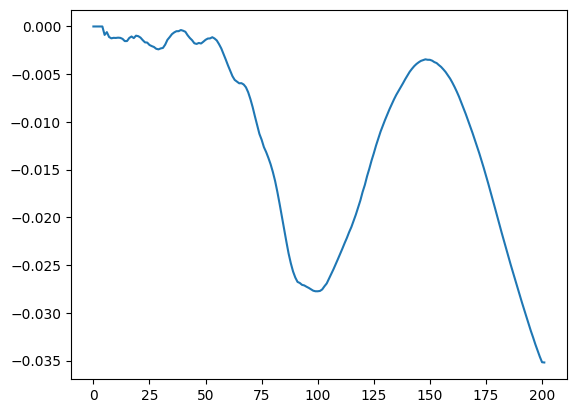

In [144]:
import matplotlib.pyplot as plt
plt.plot(error)

In [96]:
m = np.where(resultant_vel>0)
node_mass[m[0]].sum()*0.5

np.float64(1.977169736)

In [85]:
(node_mass * resultant_vel**2).sum()/2

np.float64(197.71697360000002)

In [20]:
print(velocity_fc[0].data)

[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 ...
 [  0.   0. -10.]
 [  0.   0. -10.]
 [  0.   0. -10.]]


In [12]:
m = sorted(node_mass_dict.items())
m

[(1, 0.0006881825),
 (2, 0.001376365),
 (3, 0.001376365),
 (4, 0.001376365),
 (5, 0.001376365),
 (6, 0.001376365),
 (7, 0.001376365),
 (8, 0.001376365),
 (9, 0.001376365),
 (10, 0.001376365),
 (11, 0.001376365),
 (12, 0.001376365),
 (13, 0.001376365),
 (14, 0.001376365),
 (15, 0.001376365),
 (16, 0.001376365),
 (17, 0.0006881825),
 (18, 0.001376365),
 (19, 0.00275273),
 (20, 0.00275273),
 (21, 0.00275273),
 (22, 0.00275273),
 (23, 0.00275273),
 (24, 0.00275273),
 (25, 0.00275273),
 (26, 0.00275273),
 (27, 0.00275273),
 (28, 0.00275273),
 (29, 0.00275273),
 (30, 0.00275273),
 (31, 0.00275273),
 (32, 0.00275273),
 (33, 0.00275273),
 (34, 0.001376365),
 (35, 0.001376365),
 (36, 0.00275273),
 (37, 0.00275273),
 (38, 0.00275273),
 (39, 0.00275273),
 (40, 0.00275273),
 (41, 0.00275273),
 (42, 0.00275273),
 (43, 0.00275273),
 (44, 0.00275273),
 (45, 0.00275273),
 (46, 0.00275273),
 (47, 0.00275273),
 (48, 0.00275273),
 (49, 0.00275273),
 (50, 0.00275273),
 (51, 0.001376365),
 (52, 0.001376365

np.float64(-0.4846143408326711)

In [ ]:
resultant_veloc

array([0.01368284, 0.01368284, 0.01368284, ..., 0.00239512, 0.00239512,
       0.00239512], shape=(1940,))

In [ ]:
# Mapping of real FEM edges per element type
REAL_EDGES = {
    "QuadShell4": [
        (0,1), (1,2), (2,3), (3,0)
    ],
    "Shell4": [
        (0,1), (1,2), (2,3), (3,0)
    ],
    "Tet4": [
        (0,1), (1,2), (2,0),
        (0,3), (1,3), (2,3)
    ],
    "Hex8": [
        # Bottom square
        (0,1), (1,2), (2,3), (3,0),
        # Top square
        (4,5), (5,6), (6,7), (7,4),
        # Vertical edges
        (0,4), (1,5), (2,6), (3,7)
    ]
}

edges = np.zeros(0, dtype=int).reshape(0,3)  # N_edges x 3 (array of [n1, n2, material_id])
edges_attributes = []

for element_index, element in enumerate(mesh.elements):
    etype = str(element.type).split(".")[-1]   # element_types.Hex8 → Hex8
    node_ids = element.node_ids
    
    if etype not in REAL_EDGES:
        continue  # skip types not handled yet
    
    for i, j in REAL_EDGES[etype]:
        n1 = node_ids[i]
        n2 = node_ids[j]
        edges = np.vstack((edges, np.array([[n1, n2, material_id[element_index]],
                                            [n2, n1, material_id[element_index]]])))  # add both directions
    
edges = edges.T  # shape should be 3 x N_edges
edges = edges - 1 # convert to zero-based indexing
print("Total FEM edges:", edges.shape[1])

# remove duplicate 
edges = np.unique(edges, axis=1)
print("Total FEM edges:", edges.shape[1])


In [ ]:
# Define graph dataset
edge_index = torch.tensor(edges, dtype=torch.long)
edge_index.size()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert the edge_index tensor to a list of edge tuples
edge_list = edge_index[:2,:].t().tolist()

# Create a NetworkX graph from the edge list
G = nx.Graph()
G.add_edges_from(edge_list[:])

# Optionally, include nodes that might be isolated (e.g., person 3)
# G.add_nodes_from(range(node_features[:].size(0)))

# Generate a layout for the nodes
pos = nx.spring_layout(G, seed=42)  # fixed seed for reproducibility

# Draw the graph with labels
plt.figure(figsize=(6, 6))
nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=1)
plt.title("Visualization of the Social Network Graph")
plt.axis('off')
plt.show()

## Prepare training data

In [162]:
# Get node features 
coordinates_fc:dpf.FieldsContainer = model.results.coordinates.on_all_time_freqs.eval() # mm unit
acceleration_fc:dpf.FieldsContainer = model.results.acceleration.on_all_time_freqs.eval() # mm/ms^2 unit
velocity_fc:dpf.FieldsContainer = model.results.velocity.on_all_time_freqs.eval() # mm/ms unit
displacement_fc:dpf.FieldsContainer = model.results.displacement.on_all_time_freqs.eval() # mm unit
kinetic_energy = model.results.global_kinetic_energy.eval()
potential_energy = model.results.global_internal_energy.eval()
total_energy = model.results.global_total_energy.eval() 
# stress_field_container:dpf.FieldsContainer = model.results.stress.on_all_time_freqs.eval() # MPa unit
time = np.array(model.metadata.time_freq_support.time_frequencies.data)/1000 # second unit
delta_t = time[1:] - time[:-1]


In [183]:
v = velocity_fc[100].data[1700]
dt = delta_t[100]*1000
dx = displacement_fc[101].data[1700] - displacement_fc[100].data[1700]

dx - v * dt

DPFArray([0.00024576, 0.00024714, 0.0004962 ])

In [ ]:
time[1:] - time[:-1]

In [ ]:
all_features = []   # list of T tensors
predict_features = []
num_series = 3
num_steps = len(time)

# Step1: Extract node features for entire node at every time step
node_feat_series = [] #
for i in range(num_steps): # Start from num_series-1 to T-1
    coor = torch.from_numpy(coordinates_fc[i].data)
    acc  = torch.from_numpy(acceleration_fc[i].data)
    vel  = torch.from_numpy(velocity_fc[i].data)
    disp = torch.from_numpy(displacement_fc[i].data)
    node_feat_series.append(torch.cat([coor, acc, vel, disp], dim=1)) # (N, 12)

node_feat_series = torch.stack(node_feat_series, dim=2) # (N, 12, T) 

for t in range(num_series - 1, num_steps - 1):

    # Extract node features for entire node at time t with history
    node_feat = node_feat_series[:, :, t - num_series + 1 : t + 1]  # (N, 12, num_series)
    all_features.append(node_feat)

    # Predict residual
    x_t = node_feat_series[:,:,t]
    x_t_1 = node_feat_series[:,:,t+1]
    y_residual = x_t_1 - x_t
    predict_features.append(y_residual)

    

# Prepare training data
X_list = all_features
Y_list = predict_features

# for t in range(num_steps - 1):
    
#     # X = history features (N, 12, num_series)
#     X_list.append(all_features[t])
    
#     # Extract only the latest time slice (current state)
#     x_t     = all_features[t][:, :, -1]      # (N, 12)
#     x_tnext = all_features[t+1][:, :, -1]    # (N, 12)

#     # Compute residual
#     y_residual = x_tnext - x_t               # (N, 12)

#     # Append target
#     Y_list.append(y_residual)

# for t in range(num_steps - 1):
#     # X = history features (N, 12, num_series)
#     X_list.append(all_features[t])
    
#     # Y = next step features (N, 12, num_series)
#     x_t     = all_features[t][:, -3:]
#     x_tnext = all_features[t+1][:, -3:]
#     y_residual = x_tnext - x_t
#     Y_list.append(y_residual)

In [ ]:
t = 15
torch.sum(X_list[t+1][:,:,-1] - X_list[t][:,:,-1] - Y_list[t])


In [ ]:
import random
random.seed(42)
# Dataset for GNN
dataset = []
for t in range(len(X_list)):
    data = Data(
        x = X_list[t].float(),   # shape (N,12,num_series)
        y = Y_list[t].float(),   # shape (N,12)
        edge_index = edge_index
    )
    dataset.append(data)

# ---- SHUFFLE BEFORE SPLIT ----
# random.shuffle(dataset)

# ---- SPLIT 70/30 ----
total_samples = len(dataset)
train_size = int(total_samples * 0.75)

train_dataset = dataset[:train_size]
test_dataset  = dataset[train_size:]

print("Train:", len(train_dataset))
print("Test :", len(test_dataset))

# ---- LOADERS ----
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from sklearn.neighbors import KDTree
from torch_geometric.nn import knn_graph

torch.cuda.empty_cache()

from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

# =============================================
# 1) Simple MLP
# =============================================
def mlp(channels):
    layers = []
    for i in range(len(channels)-1):
        layers.append(nn.Linear(channels[i], channels[i+1]))
        if i < len(channels)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)


# =============================================
# 2) Build radius edges using KDTree (CPU)
# =============================================
def build_radius_edges(coords, radius=0.05):
    """
    coords: (N,3) tensor (either CPU or CUDA)
    returns: edge_index on CPU (2,E)
    """
    coords_cpu = coords.detach().cpu().numpy()
    tree = KDTree(coords_cpu)

    # Query neighbors
    neighbors = tree.query_radius(coords_cpu, r=radius)

    src, dst = [], []
    for i, neigh in enumerate(neighbors):
        for j in neigh:
            if i != j:
                src.append(i)
                dst.append(j)

    if len(src) == 0:
        # no contact edges
        return torch.empty((2,0), dtype=torch.long)

    return torch.tensor([src, dst], dtype=torch.long)


# =============================================
# 3) Merge FEM edges + radius edges
# =============================================
def combine_edges(topo_edge_index, radius_edge_index):
    """
    topo_edge_index: (2,E1) on GPU
    radius_edge_index: (2,E2) on CPU
    """
    radius_edge_index = radius_edge_index.to(topo_edge_index.device)

    if radius_edge_index.numel() == 0:
        return topo_edge_index

    merged = torch.cat([topo_edge_index, radius_edge_index], dim=1)
    merged = torch.unique(merged, dim=1)
    return merged


# =============================================
# 4) Residual Message Passing Layer
#     message = MLP(x_i - x_j)
#     update  = x_i + LayerNorm(mean(messages))
# =============================================
class ResidualContactLayer(MessagePassing):
    def __init__(self, node_dim):
        super().__init__(aggr='mean')
        self.msg_mlp = mlp([node_dim, node_dim])
        self.ln = nn.LayerNorm(node_dim)

    def forward(self, x, edge_index):
        # ---- SAFE NO-EDGE CASE ----
        if edge_index.numel() == 0:
            return x    # No neighbors → no message passing
        
        # Normal message passing
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        return self.msg_mlp(x_i - x_j)

    def update(self, aggr_out, x):
        return x + self.ln(aggr_out)

class ResidualContactLayer2(MessagePassing):
    def __init__(self, node_dim):
        super().__init__(aggr='mean')
        self.msg_mlp = mlp([node_dim, node_dim])
        # self.ln = nn.LayerNorm(node_dim)

    def forward(self, x, edge_index):
        # ---- SAFE NO-EDGE CASE ----
        if edge_index.numel() == 0:
            return x    # No neighbors → no message passing
        
        # Normal message passing
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        return self.msg_mlp(x_j - x_i)

    def update(self, aggr_out, x):
        return x + aggr_out


# =============================================
# 5) Full MeshGraphNet
# =============================================
class MeshGraphNet(nn.Module):
    def __init__(self, in_dim, latent_dim=128, n_layers=4, out_dim=12):
        super().__init__()

        # LSTM encoder for temporal features
        self.lstm = nn.LSTM(
            input_size=in_dim,     # 12 features
            hidden_size=latent_dim,
            num_layers=2,
            batch_first=False
        )

        # Encode LSTM output to latent node state
        self.encoder = mlp([latent_dim, latent_dim])

        # Message-passing layers
        self.layers_topo = nn.ModuleList([
            ResidualContactLayer2(latent_dim)
            for _ in range(n_layers)
        ])

        self.layers_radius = ResidualContactLayer2(latent_dim)

        self.add_passage = mlp([latent_dim*2, latent_dim])

        # Decoder back to output space (12)
        self.decoder = mlp([latent_dim, latent_dim, out_dim])

    def forward(self, x, topo_edge_index):
        """
        x: (N, F, T)  e.g., (1940, 12, 3)
        topo_edge_index: (2, E) FEM edges on GPU
        """

        device = topo_edge_index.device

        # -----------------------------------
        # 1. Extract coordinates at last time step
        # -----------------------------------
        coords = x[:, :3, -1].to(device)  # (N,3)

        # -----------------------------------
        # 2. LSTM temporal encoder
        # -----------------------------------
        x_lstm = x.permute(2, 0, 1)   # (T, N, F)
        _, (hn, _) = self.lstm(x_lstm)

        h0 = hn[-1]                   # (N, latent_dim)
        h_topo = self.encoder(h0)          # (N, latent_dim)
        h_radius = h_topo.clone()
        # -----------------------------------
        # 3. Build contact edges (KDTree on CPU)
        # -----------------------------------
        radius_edges = build_radius_edges(coords, radius=2.0)
        radius_edges = radius_edges.to(device)

        # # -----------------------------------
        # # 4. Combine edges
        # # -----------------------------------
        # full_edges = combine_edges(topo_edge_index, radius_edges)

        # # -----------------------------------
        # # 5. Message Passing
        # # -----------------------------------
        # if full_edges.numel() == 0:
        #     # no neighbors at all (rare)
        #     return self.decoder(h)

        for layer in self.layers_topo:
            h_topo = layer(h_topo, topo_edge_index)

        h_radius = self.layers_radius(h_radius, radius_edges)

        # combine both passages
        h = self.add_passage(torch.cat([h_topo, h_radius], dim=1))

        # -----------------------------------
        # 6. Output prediction
        # -----------------------------------
        return self.decoder(h)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_gnn = MeshGraphNet(in_dim=12, latent_dim=128, n_layers=2).to(device)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=1e-3)
criterion = nn.MSELoss()

trainable = sum(p.numel() for p in model_gnn.parameters() if p.requires_grad)
non_trainable = sum(p.numel() for p in model_gnn.parameters() if not p.requires_grad)

print("Trainable params   :", trainable)
print("Non-trainable params:", non_trainable)
print("Total params        :", trainable + non_trainable)

In [ ]:
def loss_fn(pred, target, x):
    """
    L = L_MSE(pred, target) + alpha*L_physical(displacement == x - x_initial)
    """
    # Loss due to loss mean square error
    L_mse = criterion(pred, target)
    # Loss due to physical constraint
    disp_pred = x[:, -3:, -1] + pred[:, -3:]  # predicted displacement at next step
    coor_pred = x[:, :3, -1] + pred[:, :3]  # predicted coordinates at next step
    L_physical = torch.mean
    return L_mse + L_physical

In [ ]:
epochs = 1000
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        # Find lost
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        y = batch.y.to(device)
        pred = model_gnn(x, edge_index)
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_list.append(total_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {total_loss:.6f}")

In [ ]:
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.grid()
plt.show()


In [ ]:
with torch.no_grad():
    for batch in test_loader:
        x = batch.x.to(device)
        edge_index = batch.edge_index.to(device)
        y = batch.y.to(device)
        pred = model_gnn(x, edge_index)
        loss = criterion(pred[:,3:6], y[:,3:6])
        print(f"Test Loss: {loss.item():.6f}")

In [ ]:
dataset[0]

In [ ]:
# roll out test 
t = 10
x_roll = dataset[t].x.to(device)
edge_index = dataset[t].edge_index.to(device)
x_roll
for i in range(t, num_steps-3):
    pred = model_gnn(x_roll, edge_index)
    y = dataset[i].y.to(device)
    loss = criterion(pred[:,3:6], y[:,3:6])
    print(f"Test Loss: {loss.item():.6f}")
    next_t = x[:,:,-1] + pred
    x_roll = torch.cat((x_roll[:,:,-2:-1],next_t.unsqueeze(-1)),dim=2)
